## Predicting Voting Behavior ##

< TODO: Short Project Description Here >

In [417]:
# Import libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import chi2_contingency

# Settings
pd.set_option('display.max_columns', None)

In [418]:
# Helper functions
def choose_random_color():
    colors = ['b', 'c', 'g', 'm', 'r', 'y', 'pink', 'turquoise', 'navy', 'lime', 'darkcyan', 'firebrick', 'slateblue', 'blueviolet']
    return random.choice(colors)

In [419]:
# Read in nonvoters dataset
non_voters = pd.read_csv('nonvoters_data.csv')
sample_size = len(non_voters)

# Print data types and non-null count for each feature  
non_voters.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5836 entries, 0 to 5835
Data columns (total 119 columns):
 #    Column          Non-Null Count  Dtype  
---   ------          --------------  -----  
 0    RespId          5836 non-null   int64  
 1    weight          5836 non-null   float64
 2    Q1              5836 non-null   int64  
 3    Q2_1            5836 non-null   int64  
 4    Q2_2            5836 non-null   int64  
 5    Q2_3            5836 non-null   int64  
 6    Q2_4            5836 non-null   int64  
 7    Q2_5            5836 non-null   int64  
 8    Q2_6            5836 non-null   int64  
 9    Q2_7            5836 non-null   int64  
 10   Q2_8            5836 non-null   int64  
 11   Q2_9            5836 non-null   int64  
 12   Q2_10           5836 non-null   int64  
 13   Q3_1            5836 non-null   int64  
 14   Q3_2            5836 non-null   int64  
 15   Q3_3            5836 non-null   int64  
 16   Q3_4            5836 non-null   int64  
 17   Q3_5        

count    5836.000000
mean       51.693797
std        17.071561
min        22.000000
25%        36.000000
50%        54.000000
75%        65.000000
max        94.000000
Name: ppage, dtype: float64


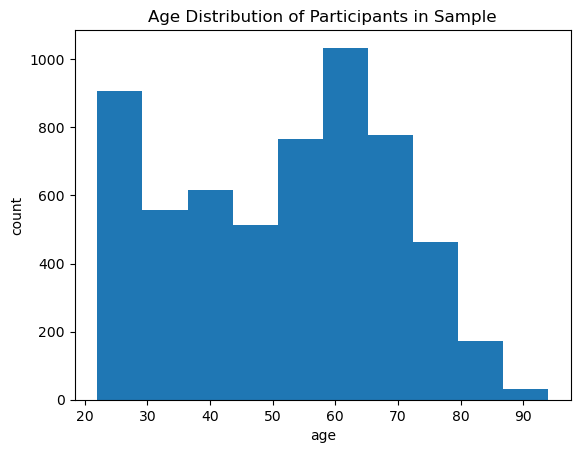

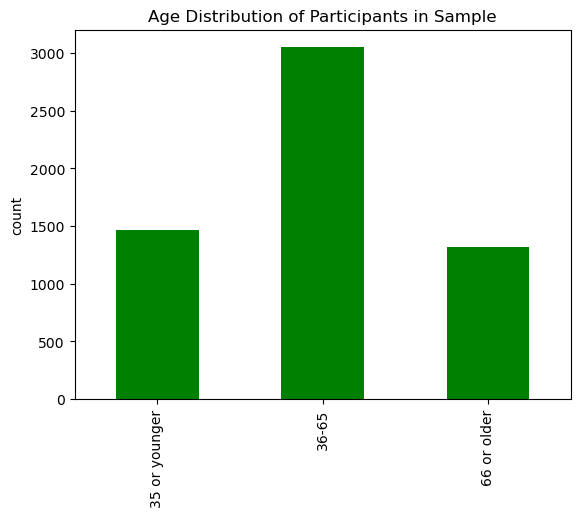

<Figure size 640x480 with 0 Axes>

In [420]:
# Change categorical features to be of type category (this is all columns except RespId, weight, and ppage)
non_categorical = ['RespId', 'weight', 'ppage']
for column in non_voters.columns:
    if column not in non_categorical:
        non_voters[column] = non_voters[column].astype('category')

# Introduce ordering to demographic features with inherent ordering
non_voters.income_cat = pd.Categorical(non_voters.income_cat, ordered=True, categories=['Less than $40k', '$40-75k', '$75-125k', '$125k or more'])
non_voters.educ = pd.Categorical(non_voters.educ, ordered=True, categories=['High school or less', 'Some college', 'College'])

# Examine age distribution of participants
print(non_voters.ppage.describe())

plt.hist(non_voters.ppage)
plt.title('Age Distribution of Participants in Sample')
plt.xlabel('age')
plt.ylabel('count')
plt.show()
plt.clf()

# Convert age feature to be catgorical instead of quantitative to improve interpretability
non_voters.ppage = pd.cut(non_voters.ppage, bins=[0, 36, 66, 99], labels=['35 or younger', '36-65', '66 or older'])
non_voters.ppage = pd.Categorical(non_voters.ppage, ordered=True, categories=['35 or younger', '36-65', '66 or older'])

# Examine new distribtuion
non_voters.ppage.value_counts().sort_index().plot(kind='bar', color=choose_random_color())
plt.title('Age Distribution of Participants in Sample')
plt.ylabel('count')
plt.show()
plt.clf()

        ppage     educ   race gender income_cat
count    5836     5836   5836   5836       5836
unique      3        3      4      2          4
top     36-65  College  White   Male   $75-125k
freq     3051     2330   3710   2940       1628


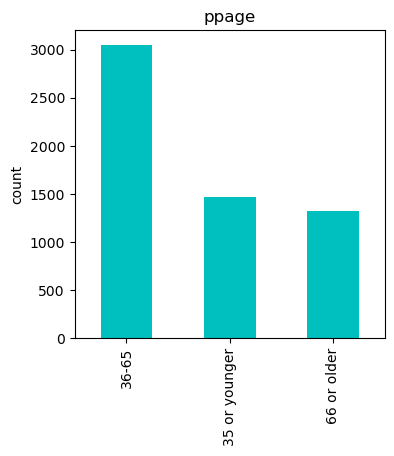

<Figure size 640x480 with 0 Axes>

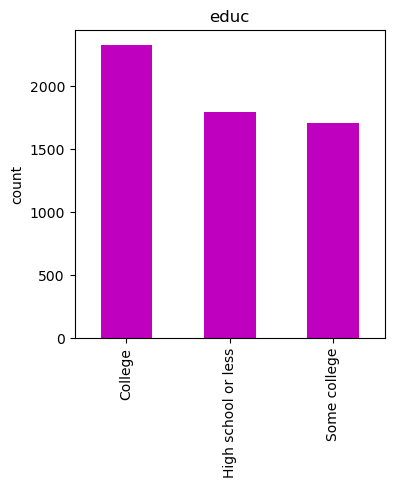

<Figure size 640x480 with 0 Axes>

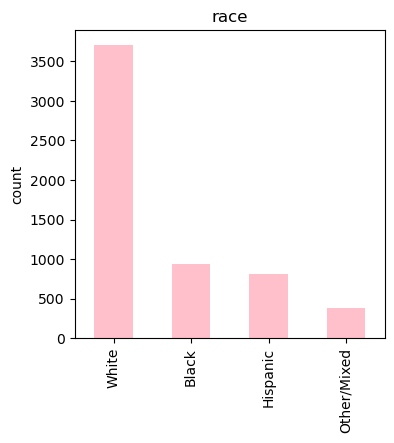

<Figure size 640x480 with 0 Axes>

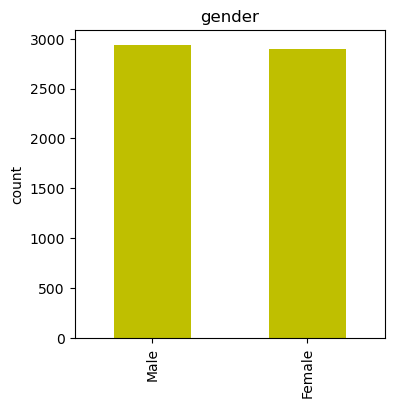

<Figure size 640x480 with 0 Axes>

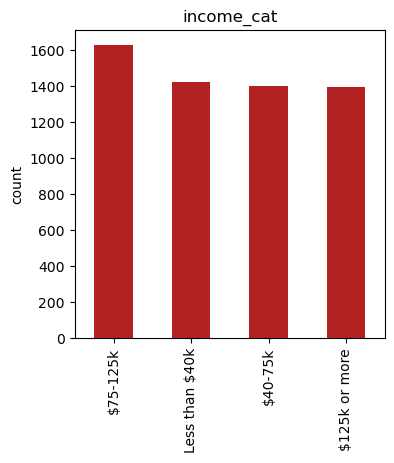

<Figure size 640x480 with 0 Axes>

In [421]:
# Examine demographics of participants in the dataset
voter_demographics = non_voters[['ppage', 'educ', 'race', 'gender', 'income_cat']].copy()
print(voter_demographics.describe(include='all'))

# Visualize distribution
for column in voter_demographics.columns:
    plt.figure(figsize=(4,4))
    voter_demographics[column].value_counts().plot(kind='bar', color=choose_random_color())
    plt.title(column)
    plt.ylabel('count')
    plt.show()
    plt.clf()

In [422]:
# Remove column for question 1 since every participant answered yes (prerequiste for being included in the sample)
non_voters.drop(f'Q1', axis=1, inplace=True)

# Remove columns for question 19 because it has a different format than the other questions
for i in range(1, 11):
    non_voters.drop(f'Q19_{i}', axis=1, inplace=True)

# Check for NA values
na_feature_count = 0
na_columns = []
for column in non_voters.columns:
    na_values = non_voters[column].isna().sum()
    if(na_values > 0):
        na_columns.append(column)
        na_feature_count += 1

print(f'{na_feature_count} features have NA values.')
print(na_columns)

# Drop all columns with NA values since they represent questions asked to a subset of participants
non_voters.drop(na_columns, axis=1, inplace=True)

22 features have NA values.
['Q22', 'Q28_1', 'Q28_2', 'Q28_3', 'Q28_4', 'Q28_5', 'Q28_6', 'Q28_7', 'Q28_8', 'Q29_1', 'Q29_2', 'Q29_3', 'Q29_4', 'Q29_5', 'Q29_6', 'Q29_7', 'Q29_8', 'Q29_9', 'Q29_10', 'Q31', 'Q32', 'Q33']


<AxesSubplot:>

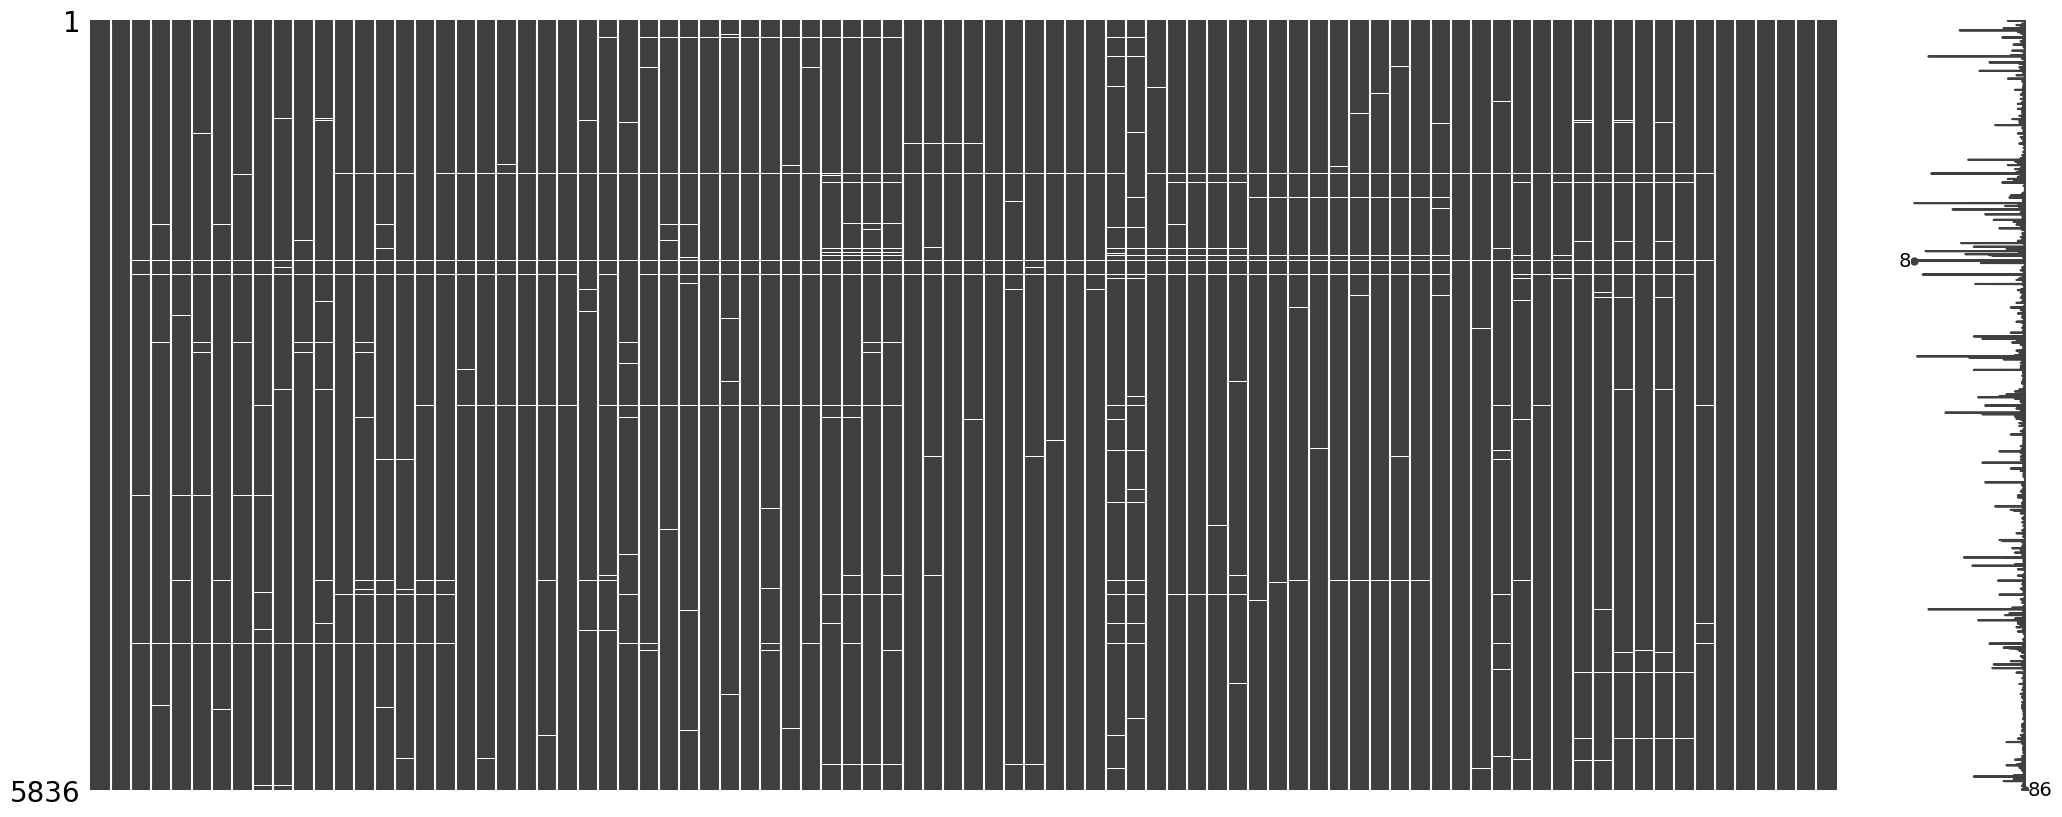

In [423]:
# Replace remaining -1 missing values with nan for easier analysis
non_voters = non_voters.replace(-1, np.nan)

# Use a missingno matrix to visually inspect if missing values are MCAR (missing completely at random)
msno.matrix(non_voters)

# for column in non_voters.columns:
#     if column not in ['RespId', 'weight']:
#         plt.figure(figsize=(4,4))
#         non_voters[column].value_counts(dropna=False).plot(kind='bar')
#         plt.title(column)
#         plt.show()
#         plt.clf()

# Since the missingness does not seem to be MCAR, use chi-square tests to check if there is a signigicant relationship 
# between participant demographics and missing values

